<a href="https://colab.research.google.com/github/alouwyck/PhD/blob/main/chapter7_two_zone_multiaquifer_systems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

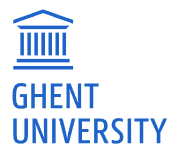<br>

**Axisymmetric Flow in Multilayer Aquifer Systems:**<br>
**Solutions and Theoretical Considerations**<br><br>
Andy Louwyck (2023)

---



---

# **CHAPTER 7: Radial Flow in Head-Dependent Two-Zone Multi-Aquifer Systems**

This Jupyter notebook implements the examples discussed in chapter 7 of my PhD thesis (Louwyck, 2023). The finite-difference simulations were done with MODFLOW or [MAxSym](https://github.com/alouwyck/MAxSym) (Louwyck, 2011; Louwyck et al., 2012), and therefore, these simulations are not included here.

## Solutions

Import the required packages, modules, and functions.

In [1]:
import numpy as np
from numpy.linalg import multi_dot as mdot
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100
import warnings
import scipy
from scipy.linalg import eig, inv, solve, LinAlgWarning, LinAlgError
from scipy.special import i0, k0, i1, k1, exp1
from scipy.optimize import fmin, fminbound, root
from math import factorial, log

Check versions:

In [2]:
# print("NumPy", np.__version__)
# print("Matplotlib", matplotlib.__version__)
# print("SciPy", scipy.__version__)

### Stehfest algorithm

Function `stehfest` implements the Stehfest (1970) algorithm:

In [4]:
def stehfest(F, t, ns=12):
    """
    Stehfest algorithm for numerical inversion of Laplace transforms.

    Parameters
    ----------
    F : callable
      Function that calculates the Laplace transform. It has frequency parameter `p` [1/T] as input
      and returns the Laplace-transform `F(p)`. Input parameter `p` is a one-dimensional numpy array,
      and the returned output is also a one-dimensional numpy array with the same length as `p`.
    t : array_like
      One-dimensional array with the real times `t` [T].
    ns : int, default: 12
       Number of terms considered in the Stehfest algorithm applied for the inversion of the Laplace solution.
       Must be a positive, even integer.

    Returns
    -------
    f : ndarray
      One-dimensional array with the numerically inverted values `f(t)`. The length of `f` equals the length of `t`.
    """
    t = np.array(t)
    if t.ndim == 0:
        t = t[np.newaxis]
    nt = len(t)
    ns = int(ns)
    ln2t = log(2) / t
    W = stehfest_weights(ns)
    f = np.zeros(nt)
    for k in range(ns):
        p = ln2t * (k + 1)
        f += W[k] * F(p)
    return f * ln2t

def stehfest_weights(ns):
    """
    Calculate weights required for applying the Stehfest algorithm.

    Parameters
    ----------
    ns : int
       Number of terms considered in the Stehfest algorithm applied for the inversion of the Laplace solution.
       Must be a positive, even integer.

    Returns
    -------
    W : ndarray
      One-dimensional array with weights, length of `W` is equal to `ns`.
    """
    fac = lambda x: float(factorial(x))
    ns2 = ns // 2
    W = np.zeros(ns)
    for j in range(1, ns + 1):
        m = min(j, ns2)
        k_0 = (j + 1) // 2
        for k in range(k_0, m + 1):
            W[j - 1] += k ** ns2 * fac(2 * k) / fac(ns2 - k) / fac(k) / fac(k - 1) / fac(j - k) / fac(2 * k - j)
        W[j - 1] *= (-1) ** (ns2 + j)
    return W

### Generalized semi-analytical multilayer-multizone solution

Class to simulate steady-state radial or parallel multilayer-multizone flow (Louwyck, 2023):

In [5]:
class MultiZoneSteady:
    """
    Class to simulate steady-state radial or parallel multilayer-multizone flow.

    Parameters
    ----------
    R : array_like
      Distances [L] of zone boundaries. The length of `R` is `nz+1` with `nz` the number of zones.
    T : array_like
      Transmissivities [L²/T]. The shape of `T` is `(nl, nz)` with `nl` the number of layers.
    c : array_like
      Vertical resistances [T]. The shape of `c` is `(nl+1, nz)`.
    Q : array_like, default: `None`
      Discharges [L³/T] at inner model boundary. The length of `Q` is `nl`.
    H : array_like, default: `None`
      Constant heads [L] at inner model boundary. The length of `H` is `nl`.
    N : array_like, default: `None`
      Recharge fluxes [L/T]. The shape of `N` is `(nl, nz)`.
    h0 : array_like, default: `None`
       Constant heads [L]. The shape of `h0` is `(nl+2, nz)`.
       Note that only `h0[0, :]`, `h0[-1, :]`, and `h0[:, -1]` are relevant for steady-state flow.
    axi : boolean, default: `True`
        Radial flow is simulated if `True`, parallel flow otherwise.

    Attributes
    ----------
    nl : int
       Number of layers
    nz : int
       Number of zones
    no_warnings : bool, default: `True`
                If `True`, the following warnings are suppressed: `RunTimeWarning` and SciPy `LinAlgWarning`.
    use_scipy_solver : bool, default is `True`
                     Indicates the solver that is applied to solve the system determining the integration constants.
                     If `True`, standard LU decomposition is applied implemented in SciPy.linalg function `solve`.
                     If `False`, a custom algorithm is applied similar to the Thomas algorithm.
    eps : float, default is `1e-16`
        Integration constants lower than `eps` are set to zero.

    Methods
    -------
    h(r) :
         Calculate hydraulic head h [L] at given distances r [L].
    qh(r) :
          Calculate radial or horizontal discharge Qh [L³/T] at given distances r [L].
    """

    def __init__(self, R, T, c, Q=None, H=None, N=None, h0=None, axi=True):
        self.R = np.array(R)
        self.T = np.array(T)
        self.c = np.array(c)
        self.Q = None if Q is None else np.array(Q)
        self.H = None if H is None else np.array(H)
        self.nl, self.nz = self.T.shape
        if N is None:
            self.N = np.zeros((self.nl, self.nz))
        else:
            self.N = np.array(N)
        if h0 is None:
            self.h0 = np.zeros((self.nl+2, self.nz))
        else:
            self.h0 = np.array(h0)
        self.axi = axi
        self.confined = np.all(np.isinf([self.c[0, :], self.c[-1, :]]), axis=0)
        self._initialized = False
        self.eps = 1e-16
        self.use_scipy_solver = True
        self.no_warnings = True

    def _ini_(self):
        if not self._initialized:
            self._Ab_()
            self._eig_()
            if self.axi:
                self._IKm_axi_()
                self._XYz_axi_()
            else:
                self._IKm_par_()
                self._XYz_par_()
            self._alpha_beta_()
            self._initialized = True

    def _Ab_(self):
        self._A = np.zeros((self.nz, self.nl, self.nl))  # (nz, nl, nl)
        self._b = np.zeros((self.nz, self.nl))  # (nz, nl)
        for k in range(self.nz):
            Tc0 = 1 / (self.T[:, k] * self.c[:-1, k])  # (nl, )
            Tc1 = 1 / (self.T[:, k] * self.c[1:, k])  # (nl, )
            self._idx = np.diag_indices(self.nl)
            irow, icol = self._idx
            A = np.zeros((self.nl, self.nl))  # (nl, nl)
            A[irow, icol] = Tc0 + Tc1
            A[irow[:-1], icol[:-1] + 1] = -Tc1[:-1]
            A[irow[:-1] + 1, icol[:-1]] = -Tc0[1:]
            self._A[k] = A
            b = self.N[:, k] / self.T[:, k]  # (nl, )
            b[0] += Tc0[0] * self.h0[0, k]
            b[-1] += Tc1[-1] * self.h0[-1, k]
            self._b[k] = b

    def _eig_(self):
        self._d = np.zeros((self.nz, self.nl))
        self._V = np.zeros((self.nz, self.nl, self.nl))
        self._iV = np.zeros((self.nz, self.nl, self.nl))
        self._v = np.zeros((self.nz, self.nl))
        self._inz = []
        self._iz = []
        self._sd = []
        for k in range(self.nz):
            d, V = eig(self._A[k])  # (nl, ), (nl, nl)
            d = np.real(d)
            inz = np.arange(self.nl)
            if self.confined[k]:
                iz = np.argmin(np.abs(d))
                inz = np.setdiff1d(inz, iz)
            else:
                iz = []
            if len(inz) > 0:
                sd = np.sqrt(d[inz])
            else:
                sd = []
            iV = inv(V)
            self._d[k] = d
            self._V[k] = V
            self._iV[k] = iV
            self._inz.append(inz)
            self._iz.append(iz)
            self._sd.append(sd)
            self._v[k] = np.dot(iV, self._b[k])

    def _IKm_axi_(self):
        self._I1 = np.zeros((self.nz, self.nl, self.nl))
        self._K1 = np.zeros((self.nz, self.nl, self.nl))
        self._m1 = np.zeros((self.nz, self.nl))
        self._I2 = np.zeros((self.nz, self.nl, self.nl))
        self._K2 = np.zeros((self.nz, self.nl, self.nl))
        self._m2 = np.zeros((self.nz, self.nl))
        for k in range(self.nz):
            I1, K1 = np.zeros(self.nl), np.zeros(self.nl)
            I2, K2 = np.zeros(self.nl), np.zeros(self.nl)
            if self.confined[k]:
                iz = self._iz[k]
                I1[iz], I2[iz] = np.log(self.R[k]), np.log(self.R[k+1])
                K1[iz], K2[iz] = 1.0, 1.0
                self._m1[k, iz] = -self._v[k][iz] * self.R[k]**2 / 4
                self._m2[k, iz] = -self._v[k][iz] * self.R[k+1]**2 / 4
            if len(self._inz[k]) > 0:
                inz = self._inz[k]
                x1, x2 = self.R[k] * self._sd[k], self.R[k+1] * self._sd[k]
                I1[inz], I2[inz] = i0(x1), i0(x2)
                I1[np.isnan(I1)] = np.inf  # i0(inf) = inf
                I2[np.isnan(I2)] = np.inf  # i0(inf) = inf
                K1[inz], K2[inz] = k0(x1), k0(x2)
                self._m1[k, inz] = self._m2[k, inz] = self._v[k][inz] / self._d[k][inz]
            self._I1[k], self._I2[k] = np.dot(self._V[k], np.diag(I1)), np.dot(self._V[k], np.diag(I2))
            self._K1[k], self._K2[k] = np.dot(self._V[k], np.diag(K1)), np.dot(self._V[k], np.diag(K2))
            self._m1[k], self._m2[k] = np.dot(self._V[k], self._m1[k]), np.dot(self._V[k], self._m2[k])

    def _IKm_par_(self):
        self._I1 = np.zeros((self.nz, self.nl, self.nl))
        self._K1 = np.zeros((self.nz, self.nl, self.nl))
        self._m1 = np.zeros((self.nz, self.nl))
        self._I2 = np.zeros((self.nz, self.nl, self.nl))
        self._K2 = np.zeros((self.nz, self.nl, self.nl))
        self._m2 = np.zeros((self.nz, self.nl))
        for k in range(self.nz):
            I1, K1 = np.zeros(self.nl), np.zeros(self.nl)
            I2, K2 = np.zeros(self.nl), np.zeros(self.nl)
            if self.confined[k]:
                iz = self._iz[k]
                I1[iz], I2[iz] = self.R[k], self.R[k+1]
                K1[iz], K2[iz] = 1.0, 1.0
                self._m1[k, iz] = -self._v[k][iz] * self.R[k]**2 / 2
                self._m2[k, iz] = -self._v[k][iz] * self.R[k+1]**2 / 2
            if len(self._inz[k]) > 0:
                inz = self._inz[k]
                x1, x2 = self.R[k] * self._sd[k], self.R[k+1] * self._sd[k]
                I1[inz], I2[inz] = np.exp(x1), np.exp(x2)
                K1[inz], K2[inz] = np.exp(-x1), np.exp(-x2)
                self._m1[k, inz] = self._m2[k, inz] = self._v[k][inz] / self._d[k][inz]
            self._I1[k], self._I2[k] = np.dot(self._V[k], np.diag(I1)), np.dot(self._V[k], np.diag(I2))
            self._K1[k], self._K2[k] = np.dot(self._V[k], np.diag(K1)), np.dot(self._V[k], np.diag(K2))
            self._m1[k], self._m2[k] = np.dot(self._V[k], self._m1[k]), np.dot(self._V[k], self._m2[k])

    def _XYz_axi_(self):
        self._X1 = np.zeros((self.nz, self.nl, self.nl))
        self._Y1 = np.zeros((self.nz, self.nl, self.nl))
        self._z1 = np.zeros((self.nz, self.nl))
        self._X2 = np.zeros((self.nz, self.nl, self.nl))
        self._Y2 = np.zeros((self.nz, self.nl, self.nl))
        self._z2 = np.zeros((self.nz, self.nl))
        for k in range(self.nz):
            TV = np.dot(np.diag(2 * np.pi * self.T[:, k]), self._V[k])
            X1, X2 = np.zeros(self.nl), np.zeros(self.nl)
            Y1, Y2 = np.zeros(self.nl), np.zeros(self.nl)
            if self.confined[k]:
                iz = self._iz[k]
                X1[iz], X2[iz] = 1.0, 1.0
                self._z1[k, iz] = -self._v[k][iz] * self.R[k]**2 / 2
                self._z2[k, iz] = -self._v[k][iz] * self.R[k+1]**2 / 2
            if len(self._inz[k]) > 0:
                inz = self._inz[k]
                x1, x2 = self.R[k] * self._sd[k], self.R[k+1] * self._sd[k]
                X1[inz], X2[inz] = x1 * i1(x1), x2 * i1(x2)
                X1[np.isnan(X1)] = np.inf  # inf*i1(inf) = inf
                X2[np.isnan(X2)] = np.inf  # inf*i1(inf) = inf
                Y1[inz], Y2[inz] = -x1 * k1(x1), -x2 * k1(x2)
                b1, b2 = np.isnan(Y1), np.isnan(Y2)
                if np.any(b1):
                    if np.all(x1[b1[inz]] < 1):
                        Y1[b1] = -1.0  # 0*k1(0) = 1
                    else:
                        Y1[b1] = 0.0  # inf*k1(inf) = 0
                if np.any(b2):
                    if np.all(x2[b2[inz]] < 1):
                        Y2[b2] = -1.0  # 0*k1(0) = 1
                    else:
                        Y2[b2] = 0.0  # inf*k1(inf) = 0
            self._X1[k], self._X2[k] = np.dot(TV, np.diag(X1)), np.dot(TV, np.diag(X2))
            self._Y1[k], self._Y2[k] = np.dot(TV, np.diag(Y1)), np.dot(TV, np.diag(Y2))
            self._z1[k], self._z2[k] = np.dot(TV, self._z1[k]), np.dot(TV, self._z2[k])

    def _XYz_par_(self):
        self._X1 = np.zeros((self.nz, self.nl, self.nl))
        self._Y1 = np.zeros((self.nz, self.nl, self.nl))
        self._z1 = np.zeros((self.nz, self.nl))
        self._X2 = np.zeros((self.nz, self.nl, self.nl))
        self._Y2 = np.zeros((self.nz, self.nl, self.nl))
        self._z2 = np.zeros((self.nz, self.nl))
        for k in range(self.nz):
            TV = np.dot(np.diag(self.T[:, k]), self._V[k])
            X1, X2 = np.zeros(self.nl), np.zeros(self.nl)
            Y1, Y2 = np.zeros(self.nl), np.zeros(self.nl)
            if self.confined[k]:
                iz = self._iz[k]
                X1[iz], X2[iz] = 1.0, 1.0
                self._z1[k, iz] = -self._v[k][iz] * self.R[k]
                self._z2[k, iz] = -self._v[k][iz] * self.R[k+1]
            if len(self._inz[k]) > 0:
                inz = self._inz[k]
                x1, x2 = self.R[k] * self._sd[k], self.R[k+1] * self._sd[k]
                X1[inz], X2[inz] = self._sd[k] * np.exp(x1), self._sd[k] * np.exp(x2)
                Y1[inz], Y2[inz] = -self._sd[k] * np.exp(-x1), -self._sd[k] * np.exp(-x2)
            self._X1[k], self._X2[k] = np.dot(TV, np.diag(X1)), np.dot(TV, np.diag(X2))
            self._Y1[k], self._Y2[k] = np.dot(TV, np.diag(Y1)), np.dot(TV, np.diag(Y2))
            self._z1[k], self._z2[k] = np.dot(TV, self._z1[k]), np.dot(TV, self._z2[k])

    def _alpha_beta_(self):
        self._alpha = np.zeros((self.nz, self.nl))
        self._beta = np.zeros((self.nz, self.nl))
        if self.use_scipy_solver:
            ab = self.__scipy_solver__()
            i = np.arange(0, 2) * self.nl
            for k in range(self.nz):
                self._beta[k] = ab[i[0]:i[1]]
                i += self.nl
                self._alpha[k] = ab[i[0]:i[1]]
                i += self.nl
            self._alpha[(np.abs(self._alpha) < self.eps) | np.isnan(self._alpha)] = 0.0
            self._beta[(np.abs(self._beta) < self.eps) | np.isnan(self._beta)] = 0.0
        else:
            self.__solver__()

    def __solver__(self):
        # check infinite values at boundaries between zones
        nz = 0
        stop = False
        while (nz < self.nz) and not stop:
            stop = np.any(np.isinf(self._I1[nz]) | np.isinf(self._X1[nz])) & \
                   np.any(np.isinf(self._I2[nz]) | np.isinf(self._X2[nz]))
            if not stop: nz += 1
        # forward
        ini = lambda: [[] for _ in range(nz)]
        F, G, H, dG, dH = ini(), ini(), ini(), ini(), ini()
        if self.Q is not None:
            A = inv(self._Y1[0], check_finite=False)
            dG[0] = np.dot(A, self._X1[0])
            dH[0] = -np.dot(A, self._z1[0] + self.Q)
        else:
            A = inv(self._K1[0], check_finite=False)
            dG[0] = np.dot(A, self._I1[0])
            dH[0] = -np.dot(A, self._m1[0] - self.H)
        for k in range(nz - 1):
            j = k + 1
            A = inv(self._K2[k], check_finite=False)
            L = inv(np.dot(A, self._I2[k]) - dG[k], check_finite=False)
            F[k] = -mdot((L, A, self._K1[j]))
            G[k] = -mdot((L, A, self._I1[j]))
            H[k] = np.dot(L, np.dot(A, self._m1[j] - self._m2[k]) - dH[k])
            A = inv(self._Y2[k], check_finite=False)
            dL = inv(np.dot(A, self._X2[k]) - dG[k], check_finite=False)
            dF = inv(-mdot((dL, A, self._Y1[j])) - F[k], check_finite=False)
            dG[j] = -np.dot(dF, mdot((dL, A, self._X1[j])) + G[k])
            dH[j] = np.dot(dF, np.dot(dL, np.dot(A, self._z1[j] - self._z2[k]) - dH[k]) - H[k])
        k = nz - 1
        try:
            A = inv(self._K2[k], check_finite=False)  # not invertible if R[nz] -> inf
            L = inv(np.dot(A, self._I2[k]) - dG[k], check_finite=False)
            H[k] = np.dot(L, np.dot(A, (self.h0[1:-1, k] - self._m2[k])) - dH[k])
        except LinAlgError:
            H[k] = np.zeros(self.nl)
        # backward
        self._alpha[k] = H[k]
        self._alpha[k][np.isnan(self._alpha[k])] = 0.0
        for k in range(nz - 2, -1, -1):
            j = k + 1
            self._beta[j] = dH[j] - np.dot(dG[j], self._alpha[j])
            self._beta[k][np.isnan(self._beta[k])] = 0.0
            self._alpha[k] = H[k] - np.dot(F[k], self._beta[j]) - np.dot(G[k], self._alpha[j])
            self._alpha[k][np.isnan(self._alpha[k])] = 0.0
        self._beta[0] = dH[0] - np.dot(dG[0], self._alpha[0])
        self._beta[0][np.isnan(self._beta[0])] = 0.0

    def __scipy_solver__(self):
        # apply scipy solve function to find alpha and beta
        n = 2 * self.nl * self.nz
        M = np.zeros((n, n))
        rhs = np.zeros(n)
        # k = 0
        i = np.arange(0, 2) * self.nl
        j = np.arange(-2, 3) * self.nl
        if self.Q is not None:
            M[i[0]:i[1], j[2]:j[3]] = -self._Y1[0]
            M[i[0]:i[1], j[3]:j[4]] = -self._X1[0]
            rhs[i[0]:i[1]] = self._z1[0] + self.Q
        else:
            M[i[0]:i[1], j[2]:j[3]] = -self._K1[0]
            M[i[0]:i[1], j[3]:j[4]] = -self._I1[0]
            rhs[i[0]:i[1]] = self._m1[0] - self.H
        # 0 < k < nz-1
        for k in range(1, self.nz):
            i += self.nl
            j += 2 * self.nl
            M[i[0]:i[1], j[0]:j[1]] = self._K2[k-1]
            M[i[0]:i[1], j[1]:j[2]] = self._I2[k-1]
            M[i[0]:i[1], j[2]:j[3]] = -self._K1[k]
            M[i[0]:i[1], j[3]:j[4]] = -self._I1[k]
            rhs[i[0]:i[1]] = self._m1[k] - self._m2[k-1]
            i += self.nl
            M[i[0]:i[1], j[0]:j[1]] = self._Y2[k-1]
            M[i[0]:i[1], j[1]:j[2]] = self._X2[k-1]
            M[i[0]:i[1], j[2]:j[3]] = -self._Y1[k]
            M[i[0]:i[1], j[3]:j[4]] = -self._X1[k]
            rhs[i[0]:i[1]] = self._z1[k] - self._z2[k-1]
        # k = nz - 1
        k = self.nz - 1
        i += self.nl
        # if np.any(np.isinf(self._I2[k])):  # outer boundary -> inf
        #     M[i[0]:i[1], j[2]:j[3]] = np.eye(self.nl)  # alpha(nz) = 0
        # else:
        M[i[0]:i[1], j[2]:j[3]] = self._K2[k]
        M[i[0]:i[1], j[3]:j[4]] = self._I2[k]
        rhs[i[0]:i[1]] = self.h0[1:-1, k] - self._m2[k]
        self._M3, self._rhs3, self._until = self.__check_M__(M.copy(), rhs.copy())
        ab = np.zeros(len(rhs))
        ab[:self._until] = solve(self._M3, self._rhs3, check_finite=False)
        self._M, self._rhs = M.copy(), rhs.copy()
        M, rhs = self.__check_inf__(M, rhs)
        M, rhs = self.__check_zero_columns__(M, rhs)
        # alpha_beta = solve(M, rhs)
        self._M2, self._rhs2 = M, rhs
        return ab
        #return solve(M, rhs, assume_a='gen', check_finite=False)

    def __check_M__(self, M, rhs):
        # check inf
        b = np.isinf(M)
        if np.any(b):
            irow, icol = np.where(b)
            until = np.min([np.min(irow), np.min(icol)])
            return M[:until, :until], rhs[:until], until
        else:
            return M, rhs, None

    def __check_zero_columns__(self, M, rhs):
        for i in np.where(np.all(M == 0, axis=0)):
            M[i, :] = 0
            M[i, i] = 1
            rhs[i] = 0
        return M, rhs

    def __check_inf__(self, M, rhs):
        b = np.any(np.isinf(M), axis=0)
        if np.any(b):
            i = np.min(np.where(b))
            M[i:, :] = 0
            M[i:, i:] = np.eye(len(M) - i)
            M[:i, i:] = 0
            rhs[i:] = 0
        return M, rhs

    def h(self, r):
        with warnings.catch_warnings():
            if self.no_warnings:
                warnings.filterwarnings('ignore', category=LinAlgWarning)  # suppress scipy.linalg warnings
                warnings.filterwarnings('ignore', category=RuntimeWarning)  # suppress runtime warnings
            self._ini_()
            r = np.array(r)
            nr = len(r)
            h = np.zeros((self.nl, nr))
            for j in range(nr):
                k = np.where((self.R[:-1] <= r[j]) & (r[j] <= self.R[1:]))[0][0]
                I, K, m = np.zeros(self.nl), np.zeros(self.nl), np.zeros(self.nl)
                if self.confined[k]:
                    iz = self._iz[k]
                    if self.axi:
                        I[iz], K[iz], m[iz] = np.log(r[j]), 1.0, -self._v[k][iz] * r[j]**2 / 4
                    else:
                        I[iz], K[iz], m[iz] = r[j], 1.0, -self._v[k][iz] * r[j]**2 / 2
                if len(self._inz[k]) > 0:
                    inz = self._inz[k]
                    x = r[j] * self._sd[k]
                    inz = self._inz[k]
                    if self.axi:
                        I[inz], K[inz], m[inz] = i0(x), k0(x), self._v[k][inz] / self._d[k][inz]
                    else:
                        I[inz], K[inz], m[inz] = np.exp(x), np.exp(-x), self._v[k][inz] / self._d[k][inz]
                Ia = I * self._alpha[k]
                Ia[np.isnan(Ia) | np.isinf(Ia)] = 0.0  # if alpha = 0 and I0 = Inf
                g = Ia + K * self._beta[k] + m
                h[:, j] = np.dot(self._V[k], g)
            return h

    def qr(self, r):
        with warnings.catch_warnings():
            if self.no_warnings:
                warnings.filterwarnings('ignore', category=LinAlgWarning)  # suppress scipy.linalg warnings
                warnings.filterwarnings('ignore', category=RuntimeWarning)  # suppress runtime warnings
            self._ini_()
            r = np.array(r)
            nr = len(r)
            qr = np.zeros((self.nl, nr))
            for j in range(nr):
                k = np.where((self.R[:-1] <= r[j]) & (r[j] <= self.R[1:]))[0][0]
                I, K, m = np.zeros(self.nl), np.zeros(self.nl), np.zeros(self.nl)
                if self.confined[k]:
                    iz = self._iz[k]
                    if self.axi:
                        I[iz], m[iz] = 1.0, -self._v[k][iz] * r[j]**2 / 2
                    else:
                        I[iz], m[iz] = 1.0, -self._v[k][iz] * r[j]
                if len(self._inz[k]) > 0:
                    inz = self._inz[k]
                    x = r[j] * self._sd[k]
                    inz = self._inz[k]
                    if self.axi:
                        I[inz], K[inz] = x * i1(x), -x * k1(x)
                        K[np.isnan(K)] = 1.0  # r -> 0: x_in * k1(x_in) = 1
                    else:
                        I[inz], K[inz] = self._sd[k] * np.exp(x), -self._sd[k] * np.exp(-x)
                Ia = I * self._alpha[k]
                Ia[np.isnan(Ia) | np.isinf(Ia)] = 0.0  # if alpha = 0 and I1 = Inf
                dg = Ia + K * self._beta[k] + m
                TV = np.dot(np.diag(2 * np.pi * self.T[:, k]), self._V[k])
                qr[:, j] = np.dot(-TV, dg)
            return qr

Class to simulate transient-state radial or parallel multilayer-multizone flow (Louwyck, 2023):

In [6]:
class MultiZoneTransient:
    """
    Class to simulate transient-state radial or parallel multilayer-multizone flow.
    The Stehfest algorithm is applied to numerically invert the Laplace transform.

    Parameters
    ----------
    R : array_like
      Distances [L] of zone boundaries. The length of `R` is `nz+1` with `nz` the number of zones.
    T : array_like
      Transmissivities [L²/T]. The shape of `T` is `(nl, nz)` with `nl` the number of layers.
    S : array_like
      Storativities [-]. The shape of `S` is `(nl, nz)`.
    c : array_like
      Vertical resistances [T]. The shape of `c` is `(nl+1, nz)`.
    Q : array_like, default: `None`
      Discharges [L³/T] at inner model boundary. The length of `Q` is `nl`.
    H : array_like, default: `None`
      Constant heads [L] at inner model boundary. The length of `H` is `nl`.
    N : array_like, default: `None`
      Recharge fluxes [L/T]. The shape of `N` is `(nl, nz)`.
    h0 : array_like, default: `None`
       Initial heads [L]. The shape of `h0` is `(nl+2, nz)`.
    axi : boolean, default: `True`
        Radial flow is simulated if `True`, parallel flow otherwise.
    ns : int, default: `12`
       Number of Stehfest parameters

    Attributes
    ----------
    nl : int
       Number of layers
    nz : int
       Number of zones
    no_warnings : bool, default: `True`
                If `True`, the following warnings are suppressed: `RunTimeWarning` and SciPy `LinAlgWarning`.
    use_scipy_solver : bool, default is `True`
                     Indicates the solver that is applied to solve the system determining the integration constants.
                     If `True`, standard LU decomposition is applied implemented in SciPy.linalg function `solve`.
                     If `False`, a custom algorithm is applied similar to the Thomas algorithm.
    eps : float, default is `1e-16`
        Integration constants lower than `eps` are set to zero.

    Methods
    -------
    h(r, t) :
            Calculate hydraulic head h [L] at given distances r [L] and times [T].
    qh(r, t) :
             Calculate radial or horizontal discharge Qh [L³/T] at given distances r [L] and times [T].
    """

    def __init__(self, R, T, S, c, Q=None, H=None, N=None, h0=None, axi=True, ns=12):
        self.R = np.array(R)
        self.T = np.array(T)
        self.S = np.array(S)
        self.c = np.array(c)
        self.Q = None if Q is None else np.array(Q)
        self.H = None if H is None else np.array(H)
        self.nl, self.nz = self.T.shape
        if N is None:
            self.N = np.zeros((self.nl, self.nz))
        else:
            self.N = np.array(N)
        if h0 is None:
            self.h0 = np.zeros((self.nl+2, self.nz))
        else:
            self.h0 = np.array(h0)
        self.confined = np.all(np.isinf([self.c[0, :], self.c[-1, :]]), axis=0)
        self.axi = axi
        self.ns = int(ns)
        self._W = stehfest_weights(self.ns)
        self.use_scipy_solver = True
        self.eps = 1e-16
        self.no_warnings = True

    def h(self, r, t):
        with warnings.catch_warnings():
            if self.no_warnings:
                warnings.filterwarnings('ignore', category=LinAlgWarning)  # suppress scipy.linalg warnings
                warnings.filterwarnings('ignore', category=RuntimeWarning)  # suppress runtime warnings
            h = np.zeros((self.nl, len(r), len(t)))
            for i in range(len(t)):
                ln2t = np.log(2) / t[i]
                for j in range(self.ns):
                    p = ln2t * (j + 1)
                    if self.Q is not None:
                        m = MultiZoneSteady(self.R, self.T, self.c, Q=self.Q/p, N=self.N/p, h0=self.h0/p, axi=self.axi)
                    else:
                        m = MultiZoneSteady(self.R, self.T, self.c, H=self.H/p, N=self.N/p, h0=self.h0/p, axi=self.axi)
                    self._steady = m
                    m.eps = self.eps
                    m.no_warnings = self.no_warnings
                    m.use_scipy_solver = self.use_scipy_solver
                    m.confined = np.zeros(self.nz, dtype=bool)
                    m._Ab_()
                    for k in range(m.nz):
                        ST = self.S[:, k] / self.T[:, k]
                        m._A[k][m._idx] += ST * p
                        m._b[k] += ST * self.h0[1:-1, k]
                    m._eig_()
                    if self.axi:
                        m._IKm_axi_()
                        m._XYz_axi_()
                    else:
                        m._IKm_par_()
                        m._XYz_par_()
                    m._alpha_beta_()
                    m._initialized = True
                    h[:, :, i] += self._W[j] * m.h(r)
                h[:, :, i] *= ln2t
            return h

    def qr(self, r, t):
        with warnings.catch_warnings():
            if self.no_warnings:
                warnings.filterwarnings('ignore', category=LinAlgWarning)  # suppress scipy.linalg warnings
                warnings.filterwarnings('ignore', category=RuntimeWarning)  # suppress runtime warnings
            qr = np.zeros((self.nl, len(r), len(t)))
            for i in range(len(t)):
                ln2t = np.log(2) / t[i]
                for j in range(self.ns):
                    p = ln2t * (j + 1)
                    if self.Q is not None:
                        m = MultiZoneSteady(self.R, self.T, self.c, Q=self.Q/p, N=self.N/p, h0=self.h0/p, axi=self.axi)
                    else:
                        m = MultiZoneSteady(self.R, self.T, self.c, H=self.H/p, N=self.N/p, h0=self.h0/p, axi=self.axi)
                    self._steady = m
                    m.eps = self.eps
                    m.no_warnings = self.no_warnings
                    m.use_scipy_solver = self.use_scipy_solver
                    m.confined = np.zeros(self.nz, dtype=bool)
                    m._Ab_()
                    for k in range(m.nz):
                        ST = self.S[:, k] / self.T[:, k]
                        m._A[k][m._idx] += ST * p
                        m._b[k] += ST * self.h0[1:-1, k]
                    m._eig_()
                    if self.axi:
                        m._IKm_axi_()
                        m._XYz_axi_()
                    else:
                        m._IKm_par_()
                        m._XYz_par_()
                    m._alpha_beta_()
                    m._initialized = True
                    qr[:, :, i] += self._W[j] * m.qr(r)
                qr[:, :, i] *= ln2t
            return qr

### Theis

Function `theis` implements the solution for transient flow to a pumping well fully penetrating a confined aquifer (Theis, 1935):

In [7]:
def theis(r, t, T, S, Q):
    """
    Simulate transient flow to a pumping well fully penetrating a confined aquifer.

    Parameters
    ----------
    r : array_like
      One-dimensional array with the radial distances [L].
    t : array_like
      One-dimensional array with the simulation times [T].
    T : float
      Aquifer transmissivity [L²/T].
    S : float
      Aquifer storativity [-].
    Q : float
      Pumping rate [L³/T] of the well.

    Returns
    -------
    s : ndarray
      Drawdown [L] at distances `r` and times `t`.
      Shape of `s` is `(nr, nt)`, with `nr` the length of `r`, and `nt` the length of `t`.
    """
    t, r = np.meshgrid(t, r)
    return Q / 4 / np.pi / T * exp1(r**2 * S / 4 / t / T)

### Moench & Prickett

The following functions implement the solution for transient confined-unconfined flow to a pumping well fully penetrating a single layer (Moench & Prickett, 1972; Louwyck, 2023):

- `moench_prickett`: calculates the exact analytical solution in terms of head;
- `moench_prickett_drawdown`: calculates the exact analytical solution in terms of drawdown.
- `moench_prickett_approximate`: calculates the approximate analytical solution for late values of time.

In [8]:
def moench_prickett(r, t, T, S, Q, D, h0, R0=1, return_R=False, disp_root=False):
    """
    Simulate transient flow to a pumping well in an unconfined-confined aquifer in terms of head.

    Parameters
    ----------
    r : array_like
      One-dimensional array with the radial distances [L].
    t : array_like
      One-dimensional array with the simulation times [T].
    T : float
      Aquifer transmissivity [L²/T].
    S : array_like
      Unconfined and confined aquifer storativities [-]: S = [S1, S2] = [unconfined, confined]
    Q : float
      Pumping rate [L³/T] of the well.
      Must be positive as the function only works for pumping!
    D : float
      Aquifer thickness [L].
    h0 : float
       initial head [L] in the aquifer.
    R0 : float, default: 1.0
       Initial guess for R, the distance of the conversion between confined and unconfined flow
    return_R : bool, default: False
             If True, also return R
    disp_root : bool, default: False
              If True, display function root results.

    Returns
    -------
    h : ndarray
      Head [L] at distances `r` and times `t`.
      Shape of `h` is `(nr, nt)`, with `nr` the length of `r`, and `nt` the length of `t`.
      If return_R is True, (h, R) is returned
    """
    r, t = np.array(r), np.array(t)
    nr, nt = len(r), len(t)
    d = h0 - D
    q = Q / 4 / np.pi / T
    a = S[1] / S[0]
    u1, u2 = S[0] / 4 / t / T, S[1] / 4 / t / T
    if h0 <= D:
        v = np.inf
    else:
        f = lambda lv: Q / 4 / np.pi / T / np.exp(10**lv) - d / np.exp(10**lv*a) / exp1(10**lv*a)
        result = root(f, x0=0)
        if disp_root: print(result)
        v = 10**result.x.item() if result.success else 0.0
    h = np.zeros((nr, nt))
    R = np.zeros(nt)
    for k in range(nt):
        R[k] = np.sqrt(v * 4 * T * t[k] / S[0])
        b = r < R[k]
        if np.any(b):
            h[b, k] = D - q * (exp1(r[b]**2*u1[k]) - exp1(R[k]**2*u1[k]))
        b = ~b
        if np.any(b):
            h[b, k] = h0 - d * exp1(r[b]**2*u2[k]) / exp1(R[k]**2*u2[k])
    return (h, R) if return_R else h

In [9]:
def moench_prickett_drawdown(r, t, T, S, Q, d, R0=1, return_R=False, disp_root=False):
    """
    Simulate transient flow to a pumping well in an unconfined-confined aquifer in terms of drawdown.

    Parameters
    ----------
    r : array_like
      One-dimensional array with the radial distances [L].
    t : array_like
      One-dimensional array with the simulation times [T].
    T : float
      Aquifer transmissivity [L²/T].
    S : array_like
      Unconfined and confined aquifer storativities [-]: S = [S1, S2] = [unconfined, confined]
    Q : float
      Pumping rate [L³/T] of the well.
      Must be positive as the function only works for pumping!
    d : float
      Drawdown [L] at point of conversion,
      or d = h0 - D, with h0 the initial head [L] and D the aquifer thickness [L]
    R0 : float, default: 1.0
       Initial guess for R, the distance of the conversion between confined and unconfined flow
    return_R : bool, default: False
             If True, also return R
    disp_root : bool, default: False
              If True, display function root results.

    Returns
    -------
    s : ndarray
      Drawdown [L] at distances `r` and times `t`.
      Shape of `s` is `(nr, nt)`, with `nr` the length of `r`, and `nt` the length of `t`.
      If return_R is True, (s, R) is returned
    """
    r, t = np.array(r), np.array(t)
    nr, nt = len(r), len(t)
    q = Q / 4 / np.pi / T
    a = S[1] / S[0]
    u1, u2 = S[0] / 4 / t / T, S[1] / 4 / t / T
    if d <= 0:  # h0 <= D -> only S1 -> R = inf -> v = inf
        v = np.inf
    else:
        f = lambda lv: Q / 4 / np.pi / T / np.exp(10**lv) - d / np.exp(10**lv*a) / exp1(10**lv*a)
        result = root(f, x0=0)
        if disp_root: print(result)
        v = 10**result.x.item() if result.success else 0.0
        if disp_root: print('v = ', v)
    s = np.zeros((nr, nt))
    R = np.zeros(nt)
    for k in range(nt):
        R[k] = np.sqrt(v * 4 * T * t[k] / S[0])
        b = r < R[k]
        if np.any(b):  # S1
            s[b, k] = d + q * (exp1(r[b]**2*u1[k]) - exp1(R[k]**2*u1[k]))  # paper M&P is wrong, should be (H-b) = d
        b = ~b
        if np.any(b):  # S2
            #s[b, k] = q * np.exp(R[k]**2 * (u2[k] - u1[k])) * exp1(r[b]**2*u2[k])
            s[b, k] = d * exp1(r[b]**2*u2[k]) / exp1(R[k]**2*u2[k])
    return (s, R) if return_R else s

In [10]:
def moench_prickett_approximate(r, t, T, S, Q, d, return_R=False):
    """
    Simulate transient flow to a pumping well in an unconfined-confined aquifer.
    The simulated solution is an approximation for large values of time.

    Parameters
    ----------
    r : array_like
      One-dimensional array with the radial distances [L].
    t : array_like
      One-dimensional array with the simulation times [T].
    T : float
      Aquifer transmissivity [L²/T].
    S : array_like
      Unconfined and confined aquifer storativities [-]: S = [S1, S2] = [unconfined, confined]
    Q : float
      Pumping rate [L³/T] of the well.
      Must be positive as the function only works for pumping!
    d : float
      Drawdown [L] at point of conversion,
      or d = h0 - D, with h0 the initial head [L] and D the aquifer thickness [L]
    return_R : bool, default: False
             If True, also return R

    Returns
    -------
    s : ndarray
      Drawdown [L] at distances `r` and times `t`.
      Shape of `s` is `(nr, nt)`, with `nr` the length of `r`, and `nt` the length of `t`.
      If return_R is True, (s, R) is returned
    """
    r, t = np.array(r), np.array(t)
    nr, nt = len(r), len(t)
    q = Q / 2 / np.pi / T
    R = np.sqrt(4 * t * T / S[1] / np.exp(np.euler_gamma)) * np.exp(-d / q)
    s = np.zeros((nr, nt))
    for k in range(nt):
        b = r <= R[k]
        if np.any(b):
            s[b, k] = d + q * np.log(R[k] / r[b])
        b = ~b
        if np.any(b):
            s[b, k] = q * np.log(np.sqrt(4 * t[k] * T / S[1] / np.exp(np.euler_gamma)) / r[b])
    return (s, R) if return_R else s

### Ernst

Function `ernst` implements the analytical solution for steady flow to a fully penetrating well in an aquifer subject to uniform infiltration and drainage (Ernst, 1971):

In [11]:
def ernst(r, T, c, Q, N, rw=0, R0=1, return_R=False, disp_fmin=False):
    """
    Simulate steady flow to a pumping well in an aquifer subject to infiltration and drainage.

    Parameters
    ----------
    r : array_like
      One-dimensional array with the radial distances [L].
    T : float
      Aquifer transmissivity [L²/T].
    c : float
      Drainage resistance [T]
    N : float
      Infiltration flux [L/T].
    Q : float
      Pumping rate [L³/T] of the well.
    rw : float, default: 0.0
      Well-radius [L]
    R0 : float, default: 1.0
       Initial guess for R, the distance of the conversion between confined and unconfined flow
    return_R : bool, default: False
             If True, also return R
    disp_fmin : bool, default: False
              If True, display function fmin results.

    Returns
    -------
    s : ndarray
      Drawdown [L] at distances `r`. Length of `s` is `nr`, with `nr` the length of `r`.
      If return_R is True, (s, R) is returned
    """
    r = np.array(r)
    L = np.sqrt(T * c)
    f = lambda R: (2 * k1(R/L) / k0(R/L) + R/L) * R/L + Q/np.pi/N/L**2
    R = fmin(lambda R: np.abs(f(R)), x0=R0, disp=disp_fmin)[0]
    if disp_fmin: print('R optimal:', R)
    b = r < R
    s = np.zeros(len(b))
    if np.any(b):
        s[b] = (N*rw**2/2/T - Q/2/np.pi/T) * np.log(r[b]/R) + N/4/T * (R**2 - r[b]**2) - N * c
    b = ~b
    if np.any(b):
        s[b] = (Q + N*np.pi*R**2) / 2/np.pi/T * k0(r[b]/L) / (R/L)/k1(R/L)
    return (s, R) if return_R else s

## Multilayer head-dependent two-zone problems

Creating Figure 2 (Section 7.3.2.2):

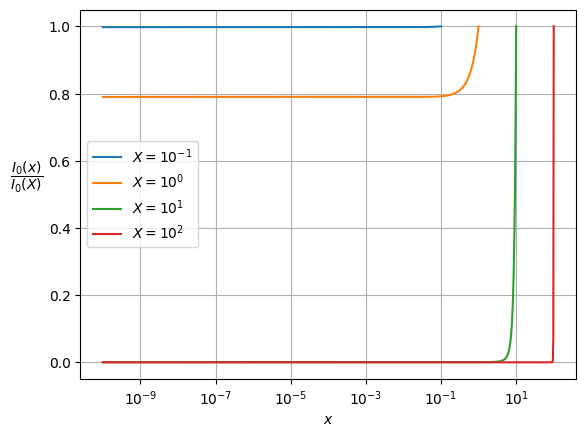

In [2]:
for X in np.logspace(-1, 2, 4):
    lX = int(np.log10(X))
    x = np.logspace(-10, lX, 1000)
    lx = np.log10(x)
    y = i0(x) / i0(X)
    y[np.isnan(y) & (lx<lX)] = 0.0
    y[np.isnan(y) & (lx==lX)] = 1.0
    plt.semilogx(x, y, label="$X = 10^{" + str(lX) + "}$");
plt.grid();
plt.xlabel('$x$');
plt.ylabel('$\dfrac{I_0(x)}{I_0(X)}$', rotation=0, horizontalalignment='right');
plt.legend();

## Confined-unconfined flow

### One-layer solution

Dimensionless parameter example (Section 7.4.4.1, Figure 3):

In [13]:
# input
t = np.logspace(-7, 5, 100)  # t*T/r**2/S1
S = np.logspace(-10, -2, 5)  # S2/S1
d = 1  # (H - D)*T/Q = sc*T/Q
S1 = 1
T = 1
Q = 1
r = 1

In [14]:
# Moench & Prickett (1972)
s = []  # s*T/Q
tR = []  # tR = t*T/R**2/S1
for i, S2 in enumerate(S):
    tmp, R = moench_prickett_drawdown(r=[r], t=t, T=T, S=[S1, S2], Q=Q, d=d, return_R=True, disp_root=False)
    s.append(-tmp[0])
    tR.append(1 / R[0]**2 * t[0])

# Theis (1935)
s1 = theis(r=[r], t=t, T=T, S=S[0], Q=-Q)
s2 = theis(r=[r], t=t, T=T, S=S1, Q=-Q)

In [15]:
# generalized semi-analytical multizone-multilayer solution (Louwyck, 2023)

models = [MultiZoneTransient(R=[0, r, np.inf], T=[[T, T]], S=[[S1, S2]], c=np.inf * np.ones((2, 2)),
                             Q=-Q, h0=[[0, 0], [-d, 0], [0, 0]])
          for S2 in S]

def get_sR(model, t):
    # returns s(R, t)
    m = MultiZoneTransient(R=model.R, T=model.T, S=model.S, c=model.c, Q=model.Q, h0=model.h0, ns=8)
    return m.h(r=model.R[[1]], t=[t]).item()

def search_tR(model, d):
    # returns t*T/R**2/S1
    return 10**fmin(lambda log_t: np.abs(-d - get_sR(model, 10**log_t)), x0=2)[0]

tR2 = [search_tR(model, 1) for model in models]
Rs = np.array([np.sqrt(t / tR2) for t in t])  # tR2 = t*T/R**2/S1 -> R = sqrt(t*T/S1/tR2)

sa = np.zeros((len(t), len(S)))
for k in range(len(t)):
    for i, S2 in enumerate(S):
        model = MultiZoneTransient(R=[0, Rs[k, i], np.inf], T=[[T, T]], S=[[S1, S2]], Q=-Q,
                                   c=np.inf * np.ones((2, 2)), h0=[[0, 0], [-d, 0], [0, 0]])
        sa[k, i] = model.h(r=[r], t=[t[k]]).squeeze()

Optimization terminated successfully.
         Current function value: 0.000002
         Iterations: 18
         Function evaluations: 36
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 18
         Function evaluations: 36
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 18
         Function evaluations: 37
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 15
         Function evaluations: 30
Optimization terminated successfully.
         Current function value: 0.000002
         Iterations: 16
         Function evaluations: 32


In [16]:
# checking tR (M&P) vs tR2 (generalized solution)
np.array(tR) / np.array(tR2)

array([0.95065936, 0.94513347, 0.90070637, 0.9496896 , 0.99967163])

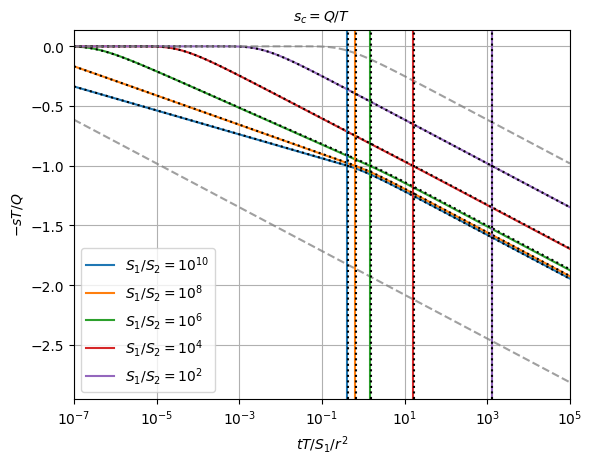

In [17]:
# creating plot (Figure 3)
lines = plt.semilogx(t, np.array(s).T, '-');
plt.legend(['$S_1/S_2=10^{' + str(int(np.log10(S1/S2))) + '}$' for S2 in S]);
plt.semilogx(t, sa, 'k:');
plt.semilogx(t, s1[0], color='gray', linestyle='--', alpha=0.75);
plt.semilogx(t, s2[0], color='gray', linestyle='--', alpha=0.75);
yl = plt.gca().get_ylim();
for i, line in enumerate(lines):
    plt.semilogx([tR[i], tR[i]], yl, color=line.get_color(), linestyle='-');#, alpha=0.75);
    plt.semilogx([tR2[i], tR2[i]], yl, 'k:');
plt.ylim(yl);
plt.xlim((t.min(), t.max()));
plt.xlabel('$tT/S_1/r^2$');
plt.ylabel('$-sT/Q$');
plt.title('$s_c=Q/T$', dict(fontsize=10));
plt.grid();

Checking the approximate M&P solution:

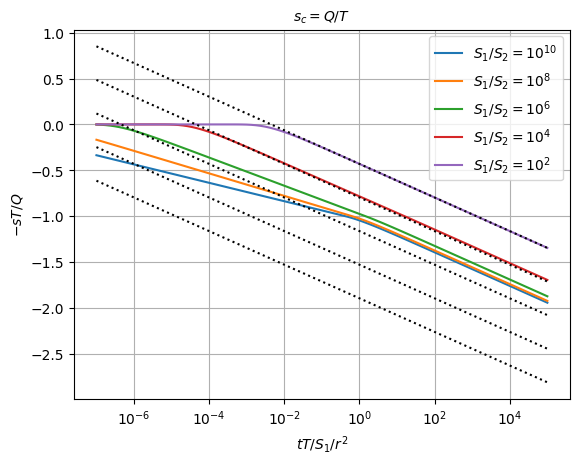

In [18]:
# approximation of M&P solution (Louwyck, 2023)

s_appr = []
for i, S2 in enumerate(S):
    s_appr.append(moench_prickett_approximate(r=[r], t=t, T=T, S=[S1, S2], Q=Q, d=d).squeeze())

plt.semilogx(t, np.array(s).T);
plt.legend(['$S_1/S_2=10^{' + str(int(np.log10(S1/S2))) + '}$' for S2 in S]);
plt.semilogx(t, -np.array(s_appr).T, 'k:');
plt.grid();
plt.xlabel('$tT/S_1/r^2$');
plt.ylabel('$-sT/Q$');
plt.title('$s_c=Q/T$', dict(fontsize=10));

In [19]:
# checking R²S1/4/t/T
U = 1 / np.array(tR) / 4
print(U)
print(U < 0.05)  # only last 2 tR are small enough indeed... (S1/S2 = 1E2 and S1/S2 = 1E4)

[6.02523058e-01 4.00608634e-01 1.75562192e-01 1.59902193e-02
 1.95325266e-04]
[False False False  True  True]


### Three-layer example

Dimensionless parameter example (Section 7.4.4.2, Figures 4 and 5):

In [20]:
# input
T = np.array([[20, 100, 250],
              [20, 100, 250]])  # transmissivities (m²/d)
S = np.array([[0.2, 5e-4, 1e-5],
              [1e-4, 5e-4, 1e-5]])  # storativities (-)
c = np.array([[np.inf, 500, 100, np.inf],
              [np.inf, 500, 100, np.inf]])  # vertical resistances (d)
Q = np.array([-100, 0, -250])  # pumping rates (m³/d)
d = -2  # (m) drawdown at point of conversion
h0 = np.array([[0, 0], [d, 0], [d, 0], [d, 0], [0, 0]])  # initial heads (m)

r = 0.1  # distance (m)
t_series = np.logspace(-6, 5, 100)  # times (m)
t = 0.1  # time (d)
r_series = np.logspace(-3, 3, 100)  # distances (m)

model = MultiZoneTransient(R=[0, 10, np.inf], T=T.T, S=S.T, c=c.T, Q=Q, h0=h0)

In [21]:
# function to calculate s(R,t)
def get_sRt(model, R, t):
    try:
        R = R[0]
    except:
        pass
    m = MultiZoneTransient(R=[0, R, np.inf], T=model.T, S=model.S, c=model.c, Q=model.Q, h0=model.h0)
    return m.h(r=[R], t=[t])[0, 0, 0]

In [22]:
# determine Rmax
Rt = 10**fmin(lambda lR: np.abs(d - get_sRt(model, 10**lR, t_series[-1])), x0=2).item()
Rt

Optimization terminated successfully.
         Current function value: 0.000051
         Iterations: 14
         Function evaluations: 28


43.33276546290165

In [23]:
# check: drawdown at R should be close to d = -2!
get_sRt(model, Rt, t_series[-1])

-2.0000512101134604

In [24]:
# determine other R(t)
Rs = []
for tk in t_series[::-1]:
    Rt = 10**fminbound(lambda lR: np.abs(d - get_sRt(model, 10**lR, tk)),
                       x1=np.log10(Rt/2), x2=np.log10(Rt))
    Rs.append(Rt)
Rs = np.array(Rs)[::-1]

In [25]:
# check min and max drawdown at all R(t)
check = np.array([-get_sRt(model, R, t) for R, t in zip(Rs, t_series)])
print(check.min(), check.max())

1.999996048140497 2.0000579808343706


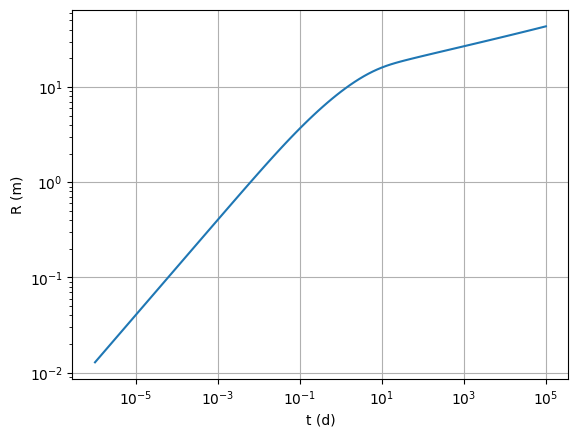

In [26]:
# R vs t plot (Figure 4)
plt.loglog(t_series, Rs, '-');
plt.xlabel('t (d)');
plt.ylabel('R (m)');
plt.grid();

In [27]:
# calculate s vs t
models = [MultiZoneTransient(R=[0, R, np.inf], T=T.T, S=S.T, c=c.T, Q=Q, h0=h0) for R in Rs]
s = np.array([model.h(r=[r], t=[t])[:, 0, 0] for t, model in zip(t_series, models)])

In [28]:
# initialize confined 1-zone model
confined = MultiZoneTransient(R=[0, np.inf], T=T[[0]].T, S=S[[1]].T, c=c[[0]].T, Q=Q)

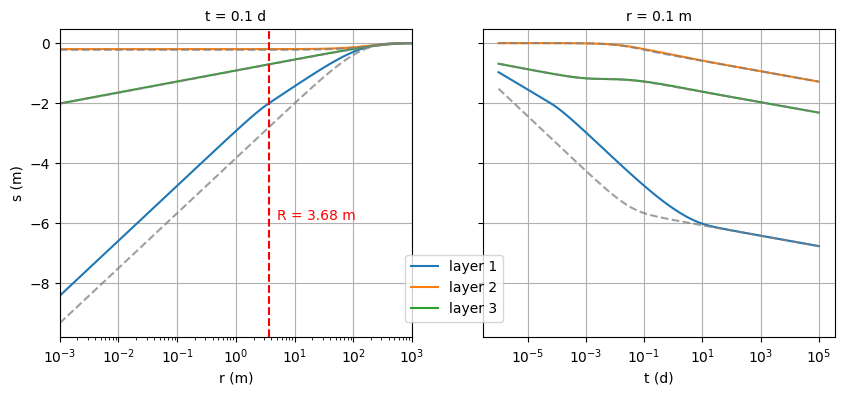

In [29]:
# drawdown plots (Figure 5)
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

k = np.argmin(np.abs(t_series - 0.1))
ax1.semilogx(r_series, models[k].h(r=r_series, t=t_series[[k]])[:, :, 0].T, '-');
ax1.semilogx(r_series, confined.h(r=r_series, t=t_series[[k]])[:, :, 0].T, color='gray', linestyle='--', alpha=0.75);
yl = ax1.get_ylim()
ax1.semilogx([Rs[k], Rs[k]], yl, 'r--');
ax1.text(5, -5.9, 'R = ' + str(np.round(Rs[k], 2)) + ' m', dict(color='red'));
ax1.set_ylim(yl);
ax1.set_xlim((1e-3, 1e3));
ax1.set_xlabel('r (m)');
ax1.set_ylabel('s (m)');
ax1.set_title('t = 0.1 d', dict(fontsize=10));
ax1.grid();

ax2.semilogx(t_series, s, '-');
xl = ax2.get_xlim();
ax2.legend(['layer ' + str(i+1) for i in range(3)], loc=(-0.22, 0.05));
ax2.semilogx(t_series, confined.h(r=[r], t=t_series)[:, 0, :].T, color='gray', linestyle='--', alpha=0.75);
ax2.set_xlim(xl);
ax2.set_xlabel('t (d)');
ax2.set_title('r = 0.1 m', dict(fontsize=10));
ax2.grid();

## Combined areal infiltration and drainage

### Steady-state one-layer solution

Dimensionless parameter example (Section 7.5.5.1, Figure 7):

In [30]:
# input
r = np.logspace(-6, 3, 100)  # r/sqrt(T*c)
Ns = np.logspace(-5, 0, 5)  # N*T*c/Q
Q = -1  # pumping: Q < 0
T = 1
c = 1
czone = np.inf * np.ones((2, 2))
czone[0, -1] = c

In [31]:
# function to calculate s(R)
def get_slR(lR):
    # lR is log10(R)
    R = 10**lR[0]
    m = MultiZoneSteady([0, R, np.inf], [[T, T]], c=czone, Q=[Q], N=[[N, 0]])
    return m.h([R])

In [32]:
# solutions
s1, R1 = [], []  # analytical solution (Ernst, 1971)
s2, R2 = [], []  # generalized semi-analytical solution (Louwyck, 2023)
for N in Ns:
    s_tmp, R_tmp = ernst(r=r, T=T, c=c, Q=Q, N=N, return_R=True);  # s*T/Q according to Ernst (1971)
    s1.append(s_tmp)
    R1.append(R_tmp)
    lRopt = fmin(lambda lR: np.abs(get_slR(lR) + N*c), x0=1, disp=False)
    R2.append(10**lRopt[0])
    m = MultiZoneSteady([0, R2[-1], np.inf], [[T, T]], c=czone, Q=[Q], N=[[N, 0]])
    s2.append(m.h(r=r).squeeze())

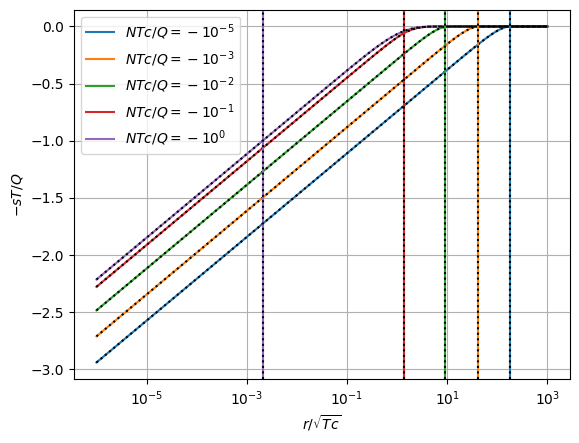

In [33]:
# plot (Figure 7)
lines = plt.semilogx(r, np.array(s1).T);
plt.legend(['$NTc/Q=-10^{' + str(int(np.log10(N))) + '}$' for N in Ns], loc='upper left');
plt.semilogx(r, np.array(s2).T, 'k:');
yl = plt.gca().get_ylim();
for i, line in enumerate(lines):
    plt.semilogx(np.array(R1)[[i, i]], yl, color=line.get_color(), linestyle='-');
    plt.semilogx(np.array(R2)[[i, i]], yl, 'k:');
plt.ylim(yl);
plt.grid();
plt.xlabel('$r/\sqrt{Tc}$');
plt.ylabel('$-sT/Q$');

### Transient-state one-layer solution

First, function `transient_ernst` is implemented to simulate the transient-state version of the Ernst (1971) model. The original semi-analytical one-layer solution developed by Louwyck et al. (2022) was implemented in Matlab. Here, the generalized semi-analytical multilayer-multizone solution developed in Chapter 5 is used.

In [34]:
# function to simulate transient Ernst model

def transient_ernst(r, t, T, S, c, Q, N, rw=0, set_h0=True, R0=1, Rmin=1e-7, return_R=False, ns=12):
    # r: radial distances [L]
    # t: times [T]
    # T: transmissivity [L²/T]
    # S: storativity [-]
    # c: drainage resistance [T]
    # Q: pumping rate [L³/T]
    # N: infiltration rate [L/T]
    # rw: well-radius [L]
    # set_h0: if True, initial head in proximal zone is set to -N*c
    # R0: initial value for R used by fmin
    # Rmin: lower bound for R
    # return_R: if True, R is returned besides drawdown s
    # ns: Stehfest number
    t = np.array(t)
    czone = np.inf * np.ones((2, 2))
    czone[0, -1] = c
    h0 = -N*c if set_h0 else 0.0
    steady = MultiZoneSteady(R=[rw, R0, np.inf], T=[[T, T]], c=czone, Q=[Q], N=[[N, 0]])
    transient = MultiZoneTransient(R=[rw, R0, np.inf], T=[[T, T]], S=[[S, S]], c=czone, Q=[Q],
                                   N=[[N, 0]], h0=[[0, 0], [h0, 0], [0, 0]], ns=ns)
    lR_upper = fmin(lambda lR: np.abs(get_sR(steady, 10**lR) + N*c), x0=np.log10(R0), disp=0)[0]
    Rt = []
    for tk in t[::-1]:
        lR_upper = fminbound(lambda lR: np.abs(get_sRt(transient, 10**lR, tk) + N*c),
                             x1=np.log10(Rmin), x2=lR_upper)
        Rt.append(10**lR_upper)
    Rt = np.array(Rt)[::-1]
    models = [MultiZoneTransient(R=[rw, R, np.inf], T=transient.T, S=transient.S, c=transient.c,
                                 Q=transient.Q, N=transient.N, h0=transient.h0, ns=transient.ns)
              for R in Rt]
    s = np.array([model.h(r=r, t=[tk]).squeeze() for model, tk in zip(models, t)]).T
    return (s, Rt) if return_R else s

# function to calculate s(R)
def get_sR(model, R):
    try:
        R = R[0]
    except:
        pass
    m = MultiZoneSteady(R=[model.R[0], R, model.R[-1]], T=model.T, c=model.c, Q=model.Q, N=model.N)
    return m.h(r=[R]).item()

# function to calculate s(R,t)
def get_sRt(model, R, t):
    try:
        R = R[0]
    except:
        pass
    m = MultiZoneTransient(R=[model.R[0], R, model.R[-1]], T=model.T, S=model.S, c=model.c,
                           Q=model.Q, N=model.N, h0=model.h0, ns=model.ns)
    return m.h(r=[R], t=[t]).item()

Dimensionless parameter example (Section 7.5.5.2, Figures 8 and 9):

In [35]:
# input
Ns = np.logspace(-3, 0, 4)  # -N*T*c/Q
Q = -1  # pumping: Q < 0
T = 1
S = 1
c = 1

In [36]:
# s vs r and h0 in proximal zone is zero
t = 100  # t/S/c
r_series = np.logspace(-3, 2, 100)  # r/sqrt(T*c)
s_r, R_r = [], []
for N in Ns:
    s_tmp, R_tmp = transient_ernst(r=r_series, t=[t], T=T, S=S, c=c, Q=Q, N=N, set_h0=False,
                                    Rmin=1e-100, return_R=True)
    s_r.append(s_tmp.squeeze())
    R_r.append(R_tmp[0])

In [37]:
# s vs r and h0 in proximal zone is -N*c
s_r_h0, R_r_h0 = [], []
for N in Ns:
    s_tmp, R_tmp = transient_ernst(r=r_series, t=[t], T=T, S=S, c=c, Q=Q, N=N, Rmin=1e-100,
                                    return_R=True)
    s_r_h0.append(s_tmp.squeeze())
    R_r_h0.append(R_tmp[0])

In [38]:
# s vs t and h0 in proximal zone is zero
t_series = np.logspace(-4, 4, 100)  # t/S/c
r = 0.01  # r/sqrt(T*c)
s_t = []
R_t = []
for N in Ns:
    s_tmp, R_tmp = transient_ernst(r=[r], t=t_series, T=T, S=S, c=c, Q=Q, N=N, set_h0=False,
                            Rmin=1e-100, return_R=True)
    s_t.append(s_tmp.squeeze())
    R_t.append(R_tmp)

In [39]:
# s vs t and h0 in proximal zone is -N*c
s_t_h0 = []
R_t_h0 = []
for N in Ns:
    s_tmp, R_tmp = transient_ernst(r=[r], t=t_series, T=T, S=S, c=c, Q=Q, N=N, Rmin=1e-100,
                                   return_R=True)
    s_t_h0.append(s_tmp.squeeze())
    R_t_h0.append(R_tmp)

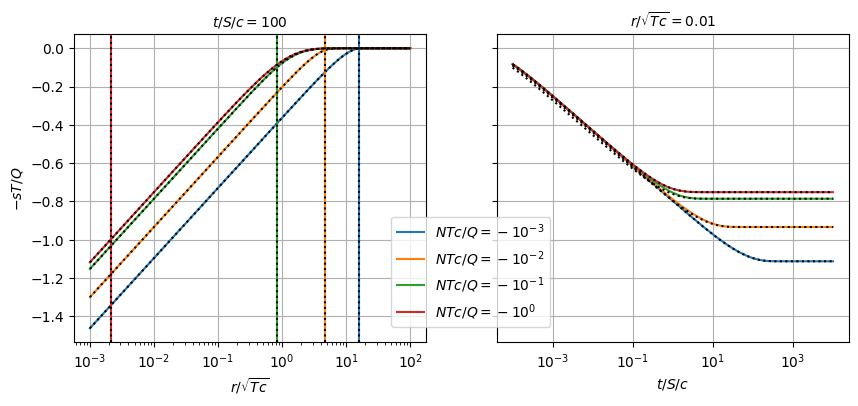

In [40]:
# drawdown plots (Figure 8)

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharey=True);

# s vs r
lines = ax1.semilogx(r_series, np.array(s_r).T);
ax1.semilogx(r_series, np.array(s_r_h0).T, 'k:');
yl = ax1.get_ylim()
for i, line in enumerate(lines):
    ax1.semilogx([R_r[i], R_r[i]], yl, color=line.get_color(), linestyle='-');
    ax1.semilogx([R_r_h0[i], R_r_h0[i]], yl, 'k:');
ax1.set_ylim(yl);
ax1.set_xlabel('$r/\sqrt{Tc}$');
ax1.set_ylabel('$-sT/Q$')
ax1.set_title('$t/S/c=100$', dict(fontsize=10));
ax1.grid();

# s vs t
ax2.semilogx(t_series, np.array(s_t).T);
ax2.semilogx(t_series, np.array(s_t_h0).T, 'k:');
ax2.legend(['$NTc/Q=-10^{' + str(int(np.log10(N))) + '}$' for N in Ns], loc=(-0.3, 0.05));
ax2.set_xlabel('$t/S/c$');
ax2.set_title('$r/\sqrt{Tc}=0.01$', dict(fontsize=10));
ax2.grid();

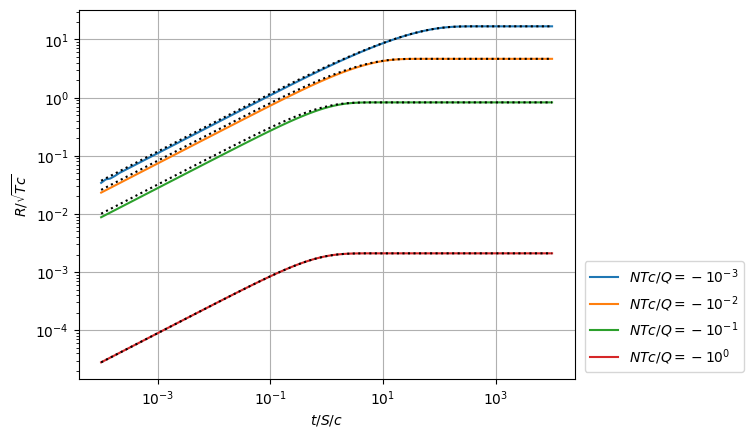

In [41]:
# R vs t plot (Figure 9)
plt.loglog(t_series, np.array(R_t).T, '-');
plt.loglog(t_series, np.array(R_t_h0).T, 'k:');
plt.xlabel('$t/S/c$')
plt.ylabel('$R/\sqrt{Tc}$')
plt.grid();
plt.legend(['$NTc/Q=-10^{' + str(int(np.log10(N))) + '}$' for N in Ns], loc=(1.02, .02));

### Three-layer example

Dimensionless parameter example (Section 7.5.5.3, Figures 10 and 11):

In [42]:
# input
T = np.array([[200, 100, 250],
              [200, 100, 250]])
S = np.array([[0.2, 0.005, 0.001],
              [0.2, 0.005, 0.001]])
c = np.array([[np.inf, 100, 500, np.inf],
              [1, 100, 500, np.inf]])
N = np.array([[0.0005, 0],
              [0, 0],
              [0, 0]])
Q = np.array([-500, 0, -250])
d = -N[0, 0] * c[1, 0]

In [43]:
# check initial heads: should be equal to N*c
ini = MultiZoneSteady(R=[0, np.inf], T=T.T[:, [0]], c=c.T[:, [-1]], N=N[:, [0]], Q=[0, 0, 0]);
r_series = np.logspace(-3, 4, 100)
h0 = ini.h(r_series)
print(h0[:, [0, -1]])
print(np.all(np.abs(h0[:, [0, -1]] - N[0, 0] * c[1, 0]) < 1e-16))

[[0.0005 0.0005]
 [0.0005 0.0005]
 [0.0005 0.0005]]
True


In [44]:
# function to calculate s(R)
def get_sR(model, R):
    try:
        R = R[0]
    except:
        pass
    m = MultiZoneSteady(R=[0, R, np.inf], T=model.T, c=model.c, Q=model.Q, N=model.N)
    return m.h(r=[R])[0, 0]

In [45]:
# function to calculate s(R,t)
def get_sRt(model, R, t):
    try:
        R = R[0]
    except:
        pass
    m = MultiZoneTransient(R=[0, R, np.inf], T=model.T, S=model.S, c=model.c, Q=model.Q, N=model.N,
                           h0=model.h0)
    return m.h(r=[R], t=[t])[0, 0, 0]

In [46]:
# steady state: Rmax
steady = MultiZoneSteady(R=[0, 100, np.inf], T=T.T, c=c.T, N=N, Q=Q);
lR_opt = fmin(lambda lR: np.abs(-h0[0, 0] - get_sR(steady, 10**lR)), 1)
R_opt = 10**lR_opt[0]
print(R_opt)

Optimization terminated successfully.
         Current function value: 0.000002
         Iterations: 18
         Function evaluations: 36
580.5868398993327


In [47]:
# transient state: R(t)
transient = MultiZoneTransient(R=[0, R_opt, np.inf], T=T.T, S=S.T, c=c.T, N=N, Q=Q,
                               h0=[[0, 0], [d, 0], [d, 0], [d, 0], [0, 0]]);
t = np.logspace(-7, 3, 150)
Rs = []
Rt = R_opt
for tk in t[::-1]:
    Rt = 10**fminbound(lambda lR: np.abs(-h0[0, 0] - get_sRt(transient, 10**lR, tk)),
                       x1=np.log10(Rt*0.5), x2=np.log10(Rt))
    Rs.append(Rt)
Rs = np.array(Rs)[::-1]

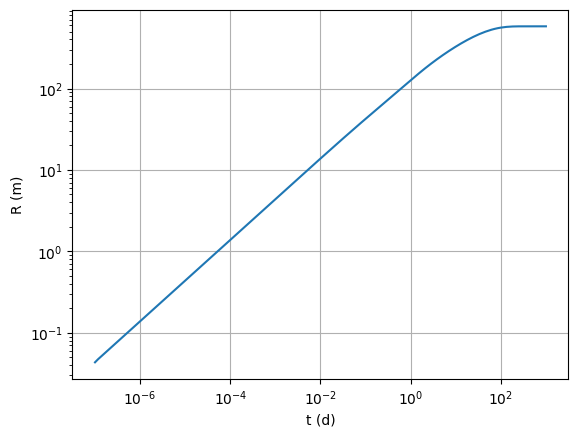

In [48]:
# plot of R(t) (Figure 11)
b = (t >= 1e-7) & (t <= 1e3)
plt.loglog(t[b], Rs[b], '-');
plt.xlabel('t (d)');
plt.ylabel('R (m)');
plt.grid();

In [49]:
# simulate h
models = [MultiZoneTransient(R=[0, R, np.inf], T=T.T, S=S.T, c=c.T, N=N, Q=Q,
                             h0=[[0, 0], [d, 0], [d, 0], [d, 0], [0, 0]])
          for R in Rs];
r = 1
h = []
for k, tk in enumerate(t):
    h.append(models[k].h(r=[r], t=[tk])[:, 0, 0])

In [50]:
# equivalent leaky model
steady = MultiZoneSteady(R=[0, R_opt, np.inf], T=T.T, c=c.T, N=N, Q=Q);
leaky_steady = MultiZoneSteady(R=[0, np.inf], T=T[[0]].T, c=c[[1]].T, Q=Q)
leaky_trans = MultiZoneTransient(R=[0, np.inf], T=T[[0]].T, S=S[[0]].T, c=c[[1]].T, Q=Q)

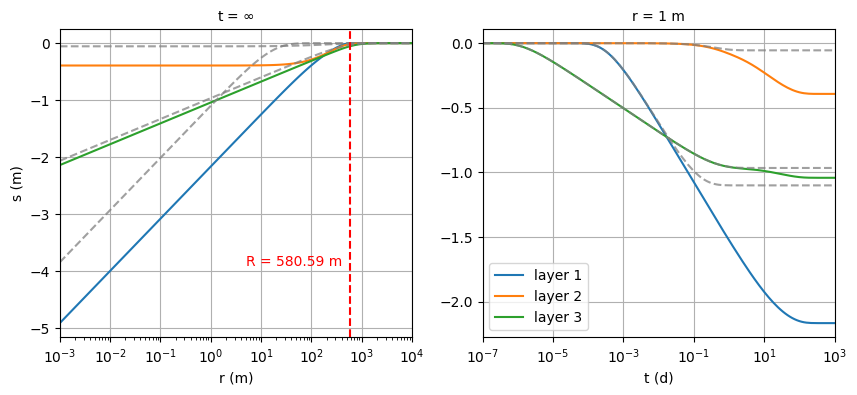

In [51]:
# drawdown plot (Figure 10)

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.semilogx(r_series, steady.h(r_series).T);
ax1.semilogx(r_series, leaky_steady.h(r_series).T, color='gray', linestyle='--', alpha=0.75);
yl = ax1.get_ylim()
ax1.semilogx([R_opt, R_opt], yl, 'r--');
ax1.text(5, -3.9, 'R = ' + str(np.round(R_opt, 2)) + ' m', dict(color='red'));
ax1.set_ylim(yl);
ax1.set_xlim((1e-3, 1e4));
ax1.set_xlabel('r (m)');
ax1.set_ylabel('s (m)');
ax1.set_title('t = $\infty$', dict(fontsize=10));
ax1.grid();

ax2.semilogx(t, np.array(h));
ax2.legend(['layer ' + str(i+1) for i in range(3)]);
ax2.semilogx(t, leaky_trans.h(t=t, r=[r]).squeeze().T, color='gray', linestyle='--', alpha=0.75);
ax2.set_xlim((1e-7, 1e3));
ax2.set_xlabel('t (d)');
ax2.set_title('r = 1 m', dict(fontsize=10));
ax2.grid();

## References

- Ernst, L. F. (1971). Analysis of groundwater flow to deep wells in areas with a non-linear function for the subsurface drainage. Journal of Hydrology, 14(2). https://doi.org/10.1016/0022-1694(71)90004-7

- Louwyck, A. (2011). MAxSym - A MATLAB Tool to Simulate Two-Dimensional Axi-Symmetric Groundwater Flow. Research Unit Groundwater Modeling, Ghent University. Retrieved from https://github.com/alouwyck/MAxSym

- Louwyck, A. (2023). Axisymmetric Flow in Multilayer Aquifer Systems: Solutions and Theoretical Considerations. PhD thesis, Laboratory for Applied Geology and Hydrogeology, Department of Geology, Ghent University, Belgium.

- Louwyck, A., Vandenbohede, A., Bakker, M., & Lebbe, L. C. (2012). Simulation of axi-symmetric flow towards wells: A finite-difference approach. Computers & Geosciences, 44, 136–145. https://doi.org/10.1016/j.cageo.2011.09.004

- Louwyck, A., Vandenbohede, A., Libbrecht, D., Van Camp, M., & Walraevens, K. (2022). The Radius of Influence Myth. Water, 14(2), 149. https://doi.org/10.3390/w14020149

- Moench, A. F., & Prickett, T. A. (1972). Radial flow in an infinite aquifer undergoing conversion from artesian to water table conditions. Water Resources Research, 8(2), 494–499. https://doi.org/10.1029/WR008i002p00494

- Stehfest, H. (1970). Algorithm 368: Numerical inversion of Laplace transforms [D5]. Communications of the ACM, 13(1), 47–49. https://doi.org/10.1145/361953.361969

- Theis, C. V. (1935). The relation between the lowering of the Piezometric surface and the rate and duration of discharge of a well using ground-water storage. Transactions, American Geophysical Union, 16(2), 519–524. https://doi.org/10.1029/TR016i002p00519



---